In [ ]:
from math import sqrt
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [ ]:
import pandas as pd
import numpy as np
spotify_songs = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-01-21/spotify_songs.csv')
Q1 = np.percentile(spotify_songs.duration_ms, 25,
                   interpolation = 'midpoint')
Q3 = np.percentile(spotify_songs.duration_ms, 75,
                   interpolation = 'midpoint')
IQR = Q3 - Q1
mask = (spotify_songs.duration_ms < (Q3+1.5*IQR))
mask2 = spotify_songs.duration_ms > (Q1-1.5*IQR)
spotify_data_cleaned = spotify_songs.loc[mask]
spotify_data_cleaned = spotify_data_cleaned.loc[mask2]
spotify_data_cleaned.track_album_release_date.str[:4]
spotify_data_cleaned.track_album_release_date.str[5:7]
spotify_data_cleaned = spotify_data_cleaned.assign(
    track_album_release_month = spotify_data_cleaned.track_album_release_date.str[5:7],
    track_album_release_year = spotify_data_cleaned.track_album_release_date.str[:4],
)
spotify_data_cleaned.drop(columns="track_album_release_date",inplace=True)
mask = (spotify_data_cleaned.track_popularity > 0)
spotify_data_cleaned = spotify_data_cleaned.loc[mask]


mask1 = spotify_data_cleaned.track_popularity <= 80
mask2 = spotify_data_cleaned.track_popularity <=60
mask3 = spotify_data_cleaned.track_popularity <=40
mask4 = spotify_data_cleaned.track_popularity <=20

spotify_data_cleaned["popularity_quali"] = "trèsPopulaire"
spotify_data_cleaned.loc[mask1,"popularity_quali"] = "bienPopulaire"
spotify_data_cleaned.loc[mask2,"popularity_quali"] = "moyennementPopulaire"
spotify_data_cleaned.loc[mask3,"popularity_quali"] = "bofPopulaire"
spotify_data_cleaned.loc[mask4,"popularity_quali"] = "pasPopulaire"

def spotify_data_short(nbTrackByGenre):
    spotify_data_short = pd.concat((spotify_data_cleaned[5000:5000+nbTrackByGenre],spotify_data_cleaned[10000:10000+nbTrackByGenre],spotify_data_cleaned[15000:15000+nbTrackByGenre],spotify_data_cleaned[20000:20000+nbTrackByGenre],spotify_data_cleaned[25000:25000+nbTrackByGenre]), axis=0)
    return spotify_data_short
    short = spotify_data_short(100)
data_short = spotify_data_short(100)
spotify_data_cleaned.track_album_release_year = spotify_data_cleaned.track_album_release_year.astype("int64")


In [ ]:
def scatterplot_pca(
    
    columns=None, hue=None, style=None, data=None, pc1=1, pc2=2, **kwargs
):
    """Diagramme de dispersion dans le premier plan principal.

    Permet d'afficher un diagramme de dispersion lorsque les données
    ont plus de deux dimensions. L'argument `columns` spécifie la
    liste des colonnes à utiliser pour la PCA dans le jeu de données
    `data`. Les arguments `style` et `hue` permettent de spécifier la
    forme et la couleur des marqueurs. Les arguments `pc1` et `pc2`
    permettent de sélectionner les composantes principales (par défaut
    la première et deuxième). Retourne l'objet `Axes` ainsi que le
    modèle `PCA` utilisé pour réduire la dimension.

    :param columns: Les colonnes quantitatives de `data` à utiliser
    :param hue: La colonne de coloration
    :param style: La colonne du style
    :param data: Le dataFrame Pandas
    :param pc1: La composante en abscisse
    :param pc2: La composante en ordonnée

    """
     # Select relevant columns (should be numeric)
    data_quant = data if columns is None else data[columns]
    data_quant = data_quant.drop(
        columns=[e for e in [hue, style] if e is not None], errors="ignore"
    )

    # Reduce to two dimensions if needed
    if data_quant.shape[1] == 2:
        data_pca = data_quant
        pca = None
    else:
        n_components = max(pc1, pc2)
        pca = PCA(n_components=n_components)
        data_pca = pca.fit_transform(data_quant)
        data_pca = pd.DataFrame(
            data_pca[:, [pc1 - 1, pc2 - 1]], columns=[f"PC{pc1}", f"PC{pc2}"]
        )

    # Keep name, force categorical data for hue and steal index to
    # avoid unwanted alignment
    if isinstance(hue, pd.Series):
        if not hue.name:
            hue.name = "hue"
        hue_name = hue.name
    elif isinstance(hue, str):
        hue_name = hue
        hue = data[hue]
    elif isinstance(hue, np.ndarray):
        hue = pd.Series(hue, name="class")
        hue_name = "class"

    hue = hue.astype("category")
    hue.index = data_pca.index
    hue.name = hue_name

    if isinstance(style, pd.Series):
        if not style.name:
            style.name = "style"
        style_name = style.name
    elif isinstance(style, str):
        style_name = style
        style = data[style]
    elif isinstance(style, np.ndarray):
        style = pd.Series(style, name="style")
        style_name = "style"

    full_data = data_pca
    if hue is not None:
        full_data = pd.concat((full_data, hue), axis=1)
        kwargs["hue"] = hue_name
    if style is not None:
        full_data = pd.concat((full_data, style), axis=1)
        kwargs["style"] = style_name

    x, y = data_pca.columns
    ax = sns.scatterplot(x=x, y=y, data=full_data, **kwargs)

    return ax, pca

<AxesSubplot:xlabel='track_album_release_month', ylabel='count'>

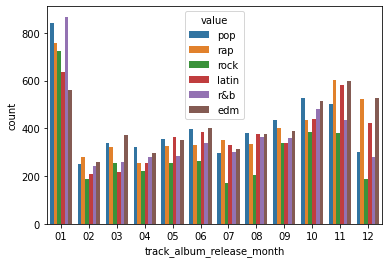

In [ ]:
mask = spotify_data_cleaned.track_album_release_month != ''
data_good_month = spotify_data_cleaned.loc[mask]
data_good_month_long = data_good_month.melt(
    id_vars=["track_album_release_month","acousticness","tempo","key","mode","track_album_release_year","track_id","loudness","track_popularity","danceability","energy","speechiness","liveness","valence","duration_ms"],
    value_vars="playlist_genre"
)

data_good_month_long.track_album_release_month = pd.Categorical(data_good_month_long.track_album_release_month, ordered=True)

sns.countplot(x="track_album_release_month", hue="value", data=data_good_month_long)

In [ ]:
spotify_data_quanti = data_short[["danceability","energy","speechiness","liveness","valence"]]

[[-1.68387190e-01 -3.69989147e-01 -2.30180558e-02 -5.03996261e-02
  -9.11967013e-01]
 [ 2.79923881e-01 -8.52929089e-01  8.87953012e-02 -3.01542633e-01
   3.08775040e-01]
 [-7.98310680e-02 -3.11826560e-01  1.28071856e-01  9.34090325e-01
   8.63947956e-02]
 [-9.10246043e-01 -1.84211146e-01 -2.34285796e-01 -1.30838604e-01
   2.55948862e-01]
 [-2.41593702e-01  6.67117012e-02  9.59319201e-01 -1.29955536e-01
   5.11780270e-04]]


<BarContainer object of 5 artists>

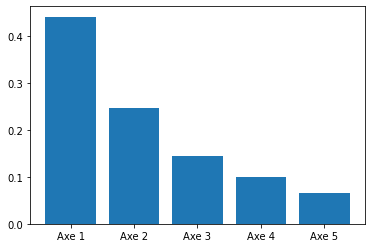

In [ ]:
cls = PCA(n_components=5)
pcs = cls.fit_transform(spotify_data_quanti)
print(cls.components_)
plt.bar(["Axe 1", "Axe 2", "Axe 3", "Axe 4", "Axe 5",], cls.explained_variance_ratio_)

<AxesSubplot:>

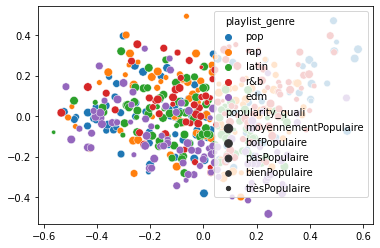

In [ ]:
sns.scatterplot(x=pcs[:,0],y=pcs[:,1],hue=data_short.playlist_genre,size=data_short.popularity_quali)

In [ ]:
data_long = spotify_data_cleaned.melt(
    id_vars=["track_album_release_month","acousticness","tempo","key","mode","track_album_release_year","track_id","loudness","track_popularity","danceability","energy","speechiness","liveness","valence","duration_ms"],
    value_vars="playlist_genre"
)

In [ ]:
#en fait faut faire gaffe pcq c'est les count et on n'a pas forcement le meme nombre de donnees dans chaque genre

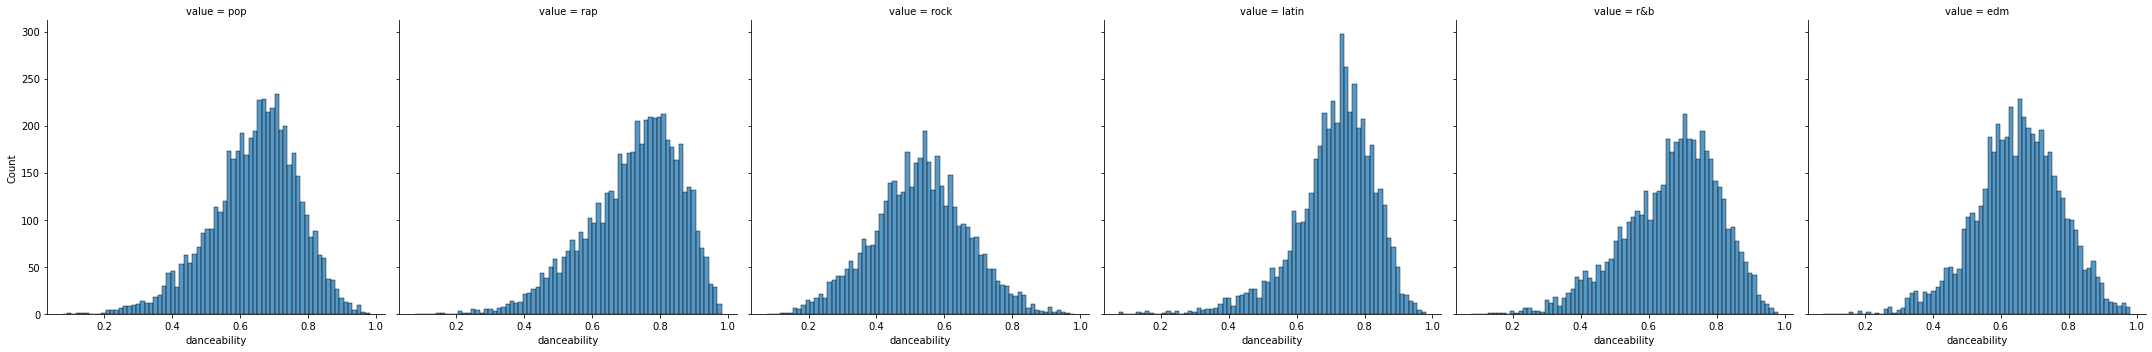

In [ ]:
sns.displot(x="danceability", col="value", kind="hist", data=data_long)

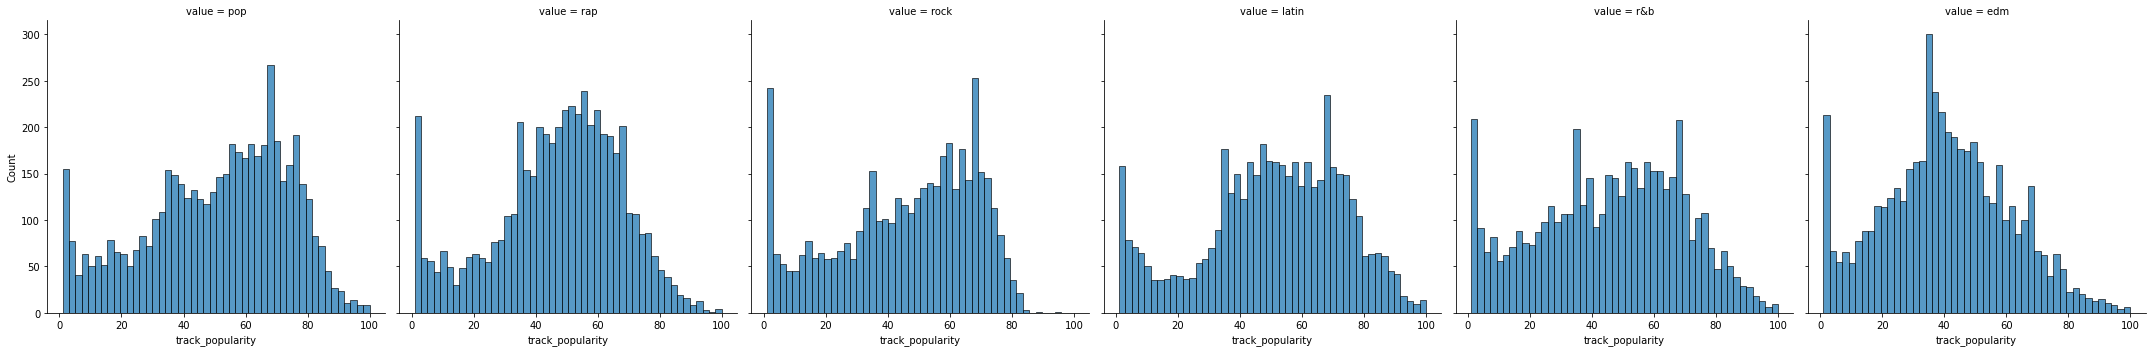

In [ ]:
sns.displot(x="track_popularity", col="value", kind="hist", data=data_long)

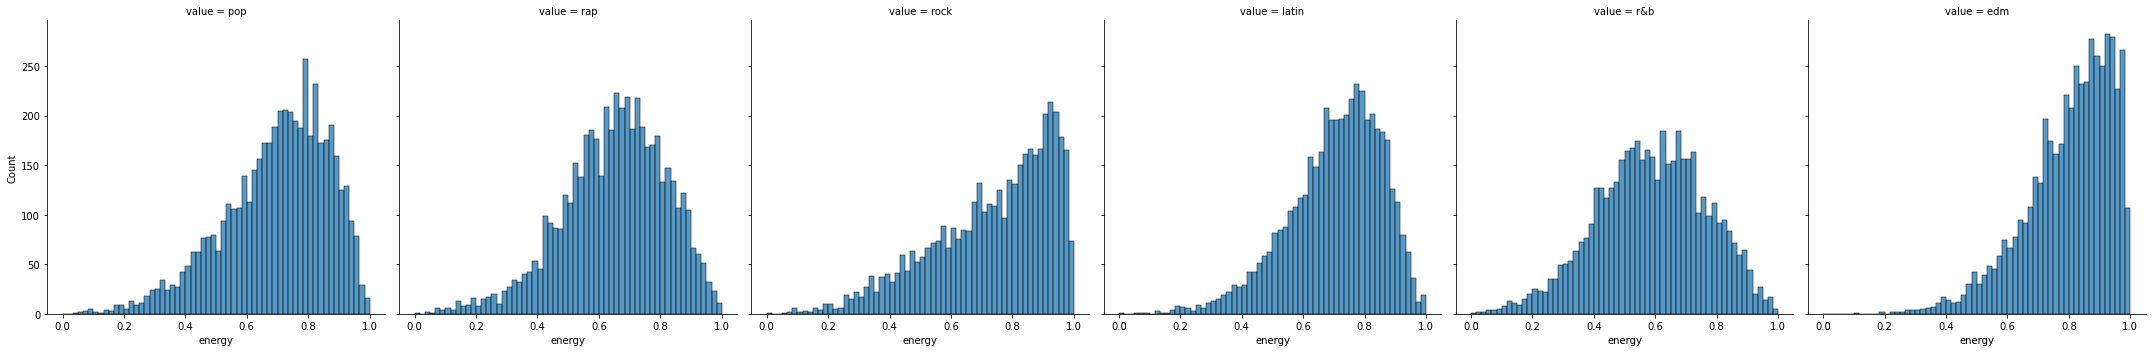

In [ ]:
sns.displot(x="energy", col="value", kind="hist", data=data_long)

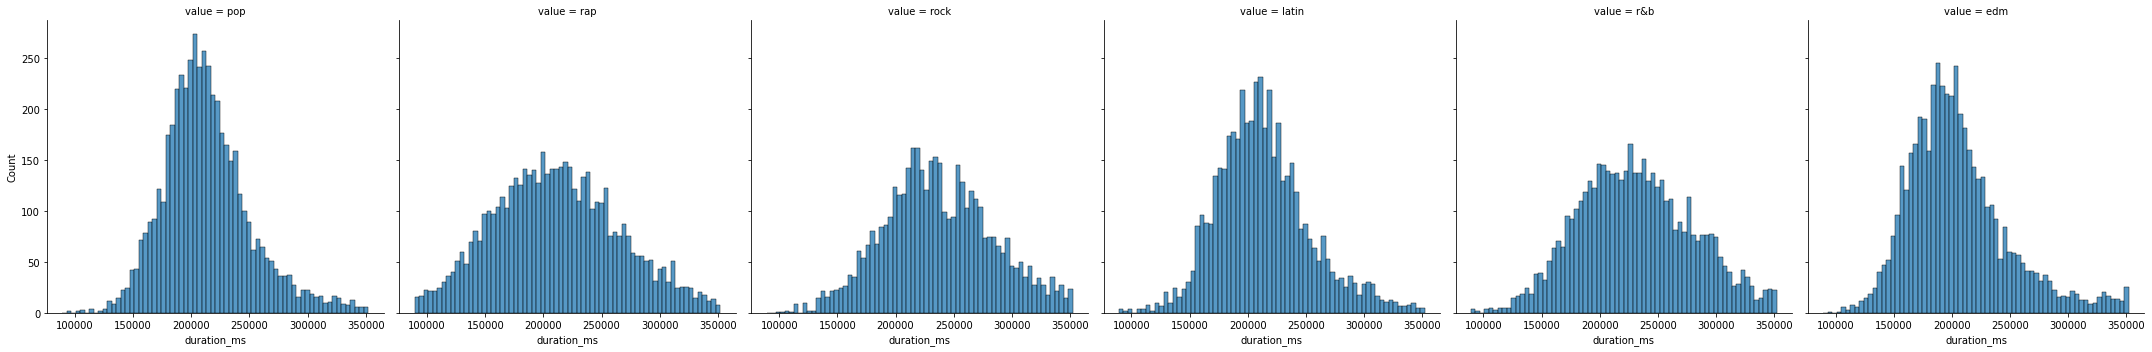

In [ ]:
sns.displot(x="duration_ms", col="value", kind="hist", data=data_long)

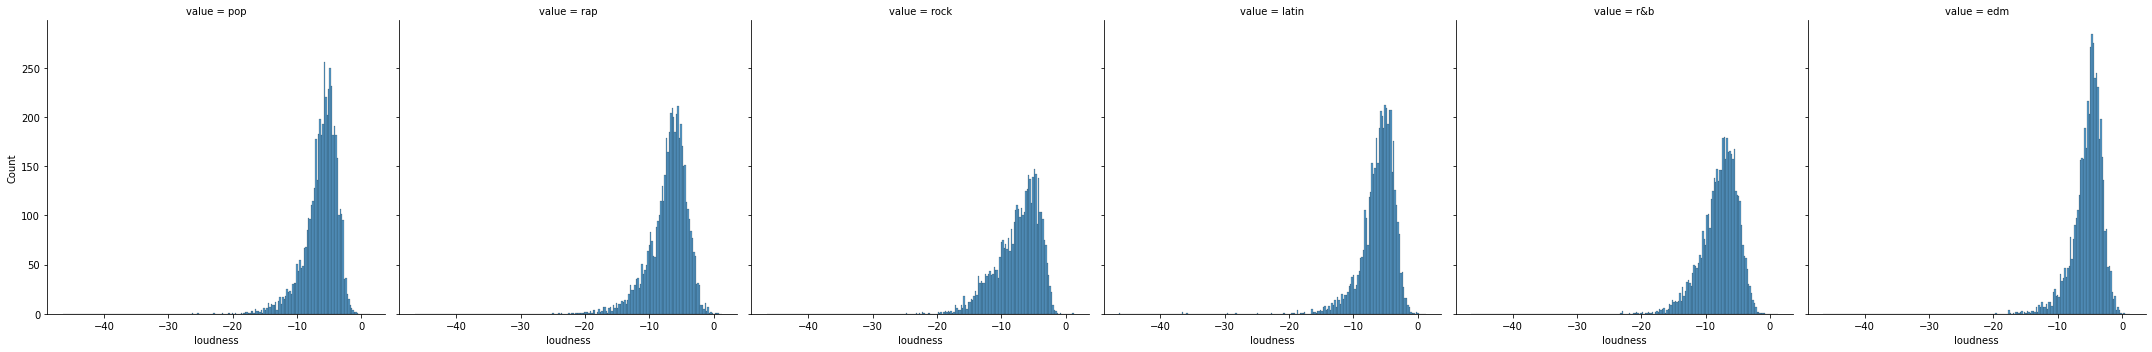

In [ ]:
sns.displot(x="loudness", col="value", kind="hist", data=data_long)

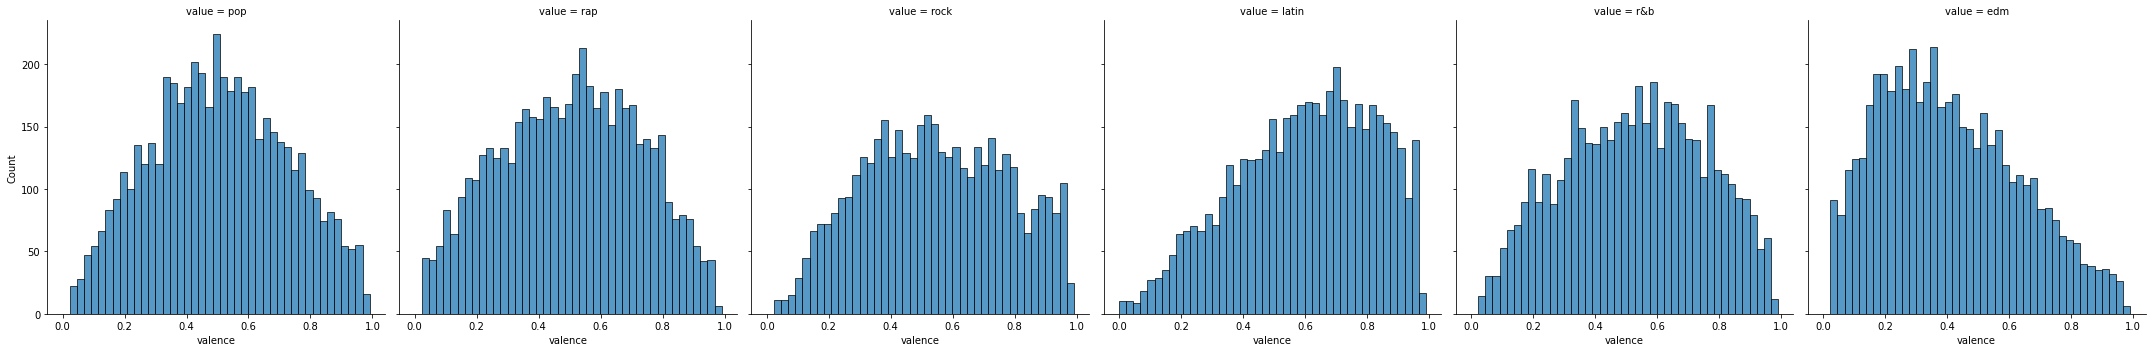

In [ ]:
sns.displot(x="valence", col="value", kind="hist", data=data_long)

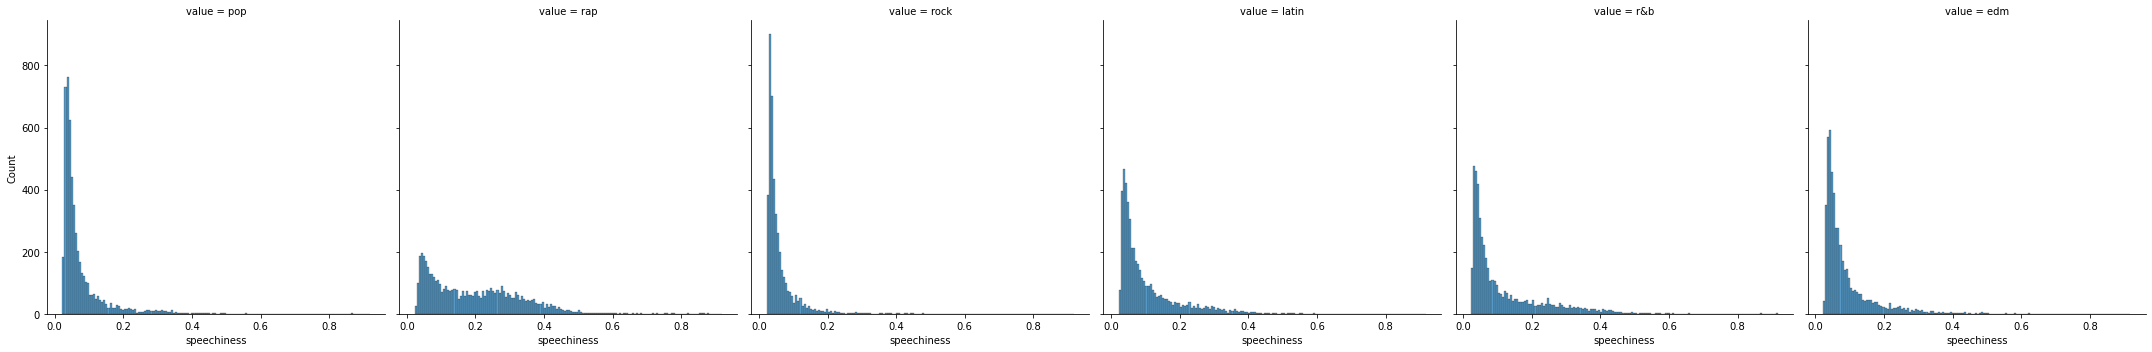

In [ ]:
sns.displot(x="speechiness", col="value", kind="hist", data=data_long)

In [ ]:
data_long_popular = spotify_data_cleaned.melt(
    id_vars=["acousticness","mode","key","track_album_release_year","tempo","loudness","track_popularity","danceability","energy","speechiness","liveness","valence","duration_ms"],
    value_vars="popularity_quali"
)

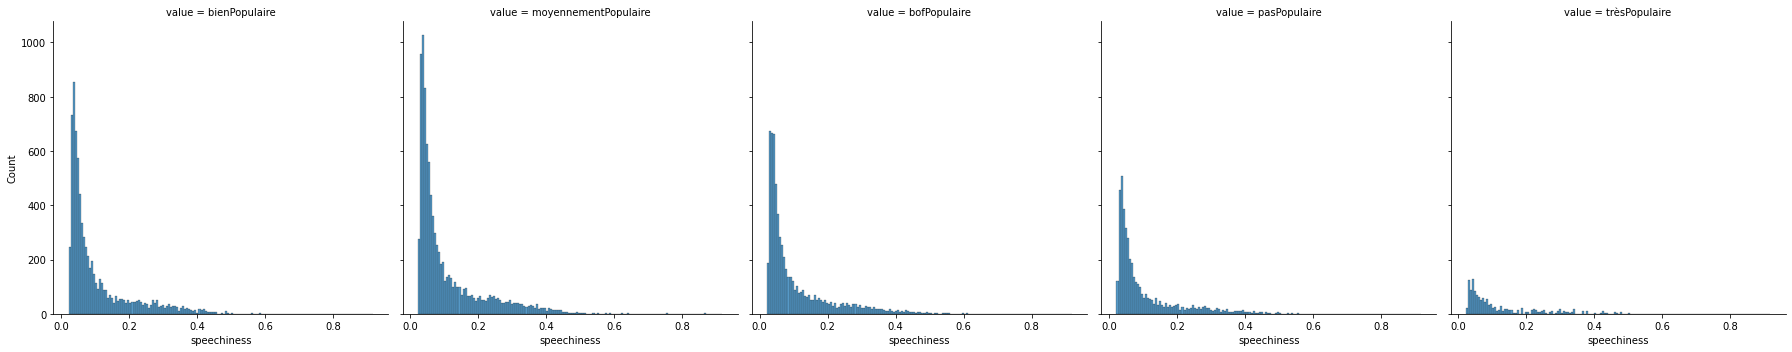

In [ ]:
sns.displot(x="speechiness", col="value", kind="hist", data=data_long_popular)

In [ ]:
mask = (data_long.value == "rap")
rapSong = data_long.loc[mask]
rapSong.track_popularity.mean()

47.00446862249854

In [ ]:
mask = (data_long.value == "rock")
rapSong = data_long.loc[mask]
rapSong.track_popularity.mean()

45.702338766832035

In [ ]:
mask = (data_long.value == "latin")
rapSong = data_long.loc[mask]
rapSong.track_popularity.mean()

50.703908241291415

In [ ]:
def variable_mean_by_genre():
    song_genre = ["rap","latin","rock","edm","r&b","pop"]
    #var_quant = ["loudness","track_popularity","danceability","energy","speechiness","liveness","valence","duration_ms"]
    var_quant = ["loudness","track_popularity","danceability","energy","speechiness","liveness","valence","duration_ms"]
    
    for genre in song_genre:
        for var in var_quant:
            mask = (data_long.value == genre)
            genreSong = data_long.loc[mask]
            if(var=="speechiness"):
                print(genre,", ", var, " : ", genreSong[str(var)].mean())

variable_mean_by_genre()

rap ,  speechiness  :  0.19445043714785312
latin ,  speechiness  :  0.1027837298215803
rock ,  speechiness  :  0.0581235766595795
edm ,  speechiness  :  0.08829751702042452
r&b ,  speechiness  :  0.11703802225488137
pop ,  speechiness  :  0.07521583790133124


<AxesSubplot:xlabel='speechiness', ylabel='value'>

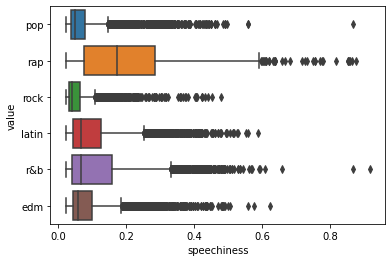

In [ ]:
sns.boxplot(x="speechiness", y="value", data=data_long)

<AxesSubplot:xlabel='danceability', ylabel='value'>

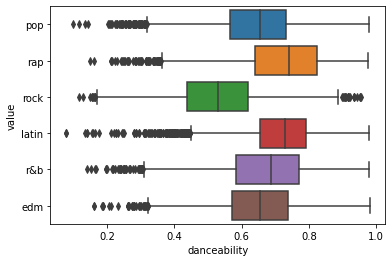

In [ ]:
sns.boxplot(x="danceability", y="value", data=data_long)

<AxesSubplot:xlabel='tempo', ylabel='value'>

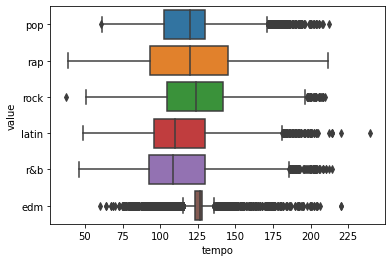

In [ ]:
sns.boxplot(x="tempo", y="value", data=data_long)

<AxesSubplot:xlabel='duration_ms', ylabel='value'>

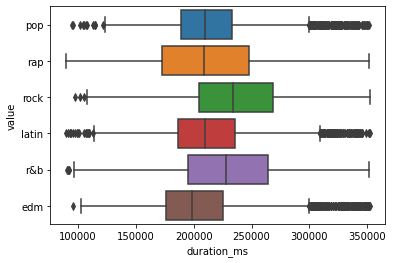

In [ ]:
sns.boxplot(x="duration_ms", y="value", data=data_long)

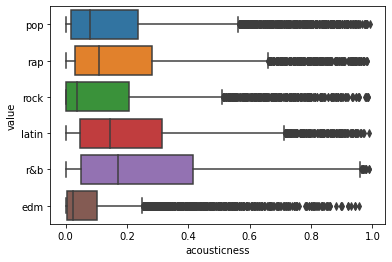

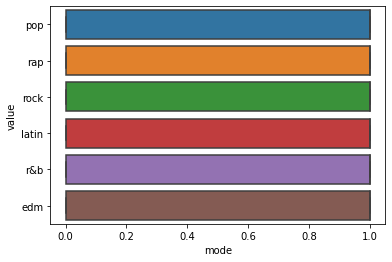

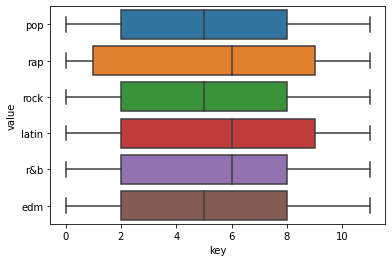

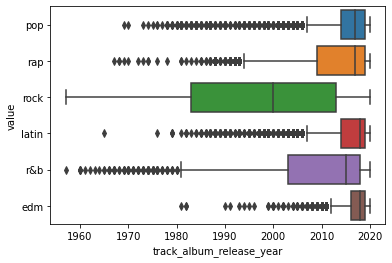

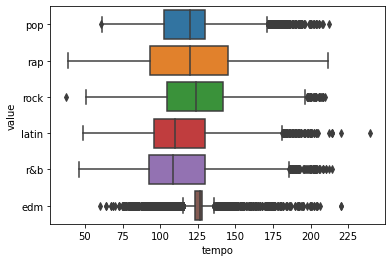

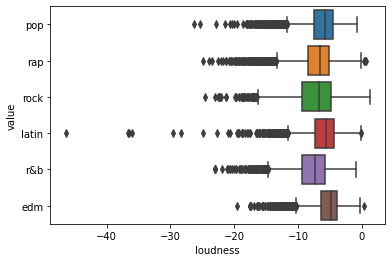

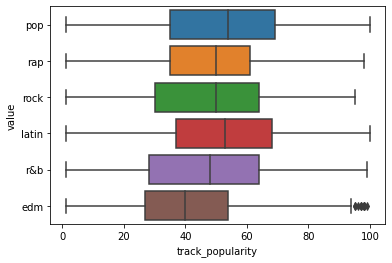

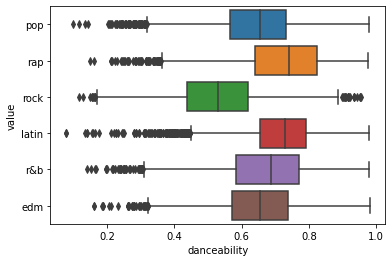

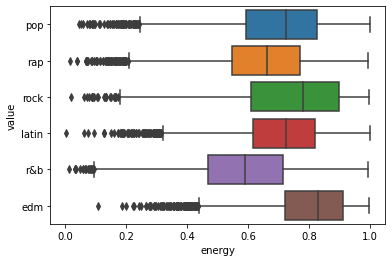

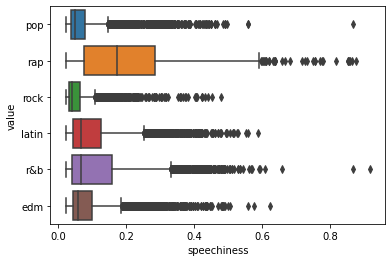

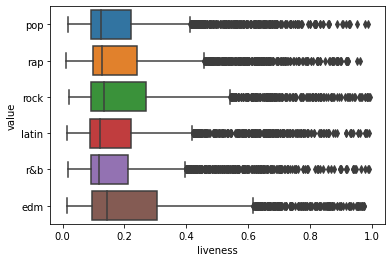

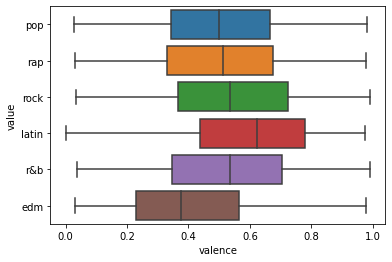

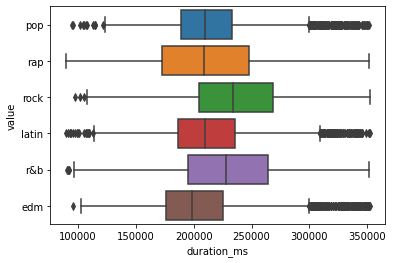

In [ ]:
var_quant = ["acousticness","mode","key","track_album_release_year","tempo","loudness","track_popularity","danceability","energy","speechiness","liveness","valence","duration_ms"]

for var in var_quant:
    sns.boxplot(x=var, y="value", data=data_long)
    plt.show()



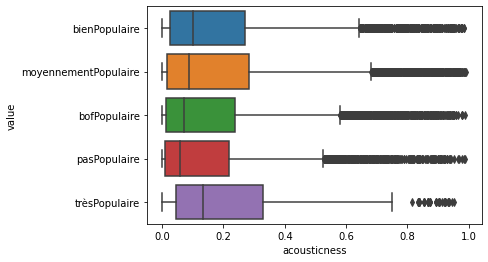

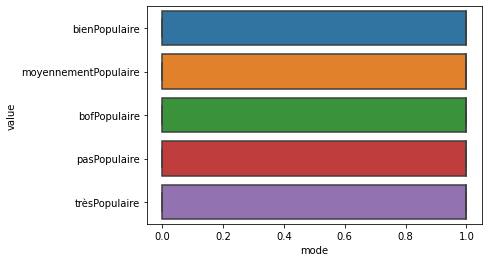

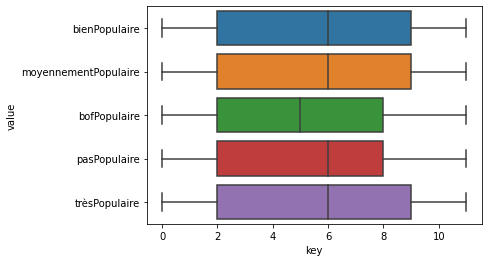

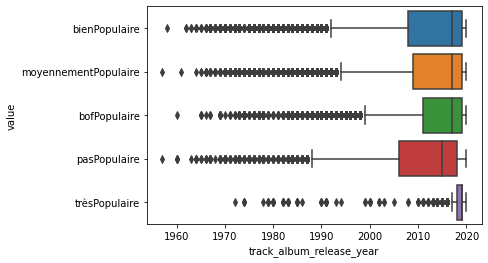

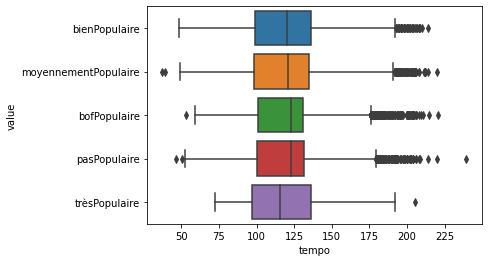

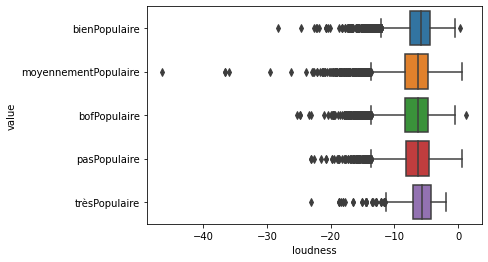

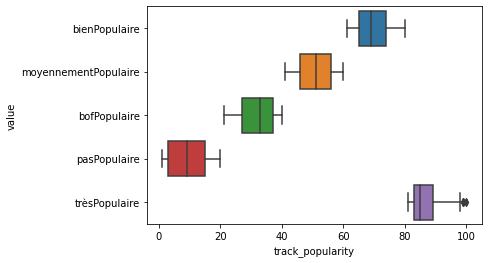

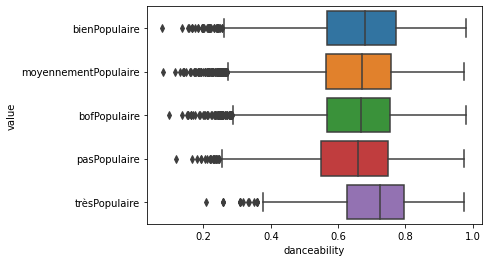

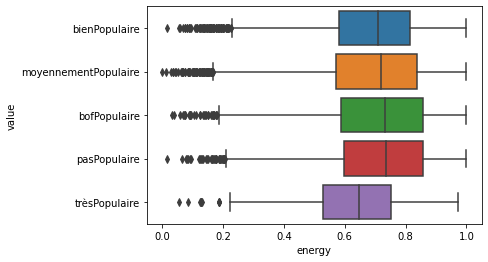

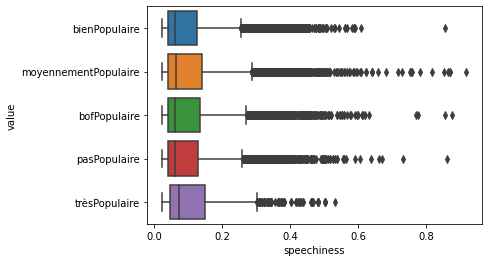

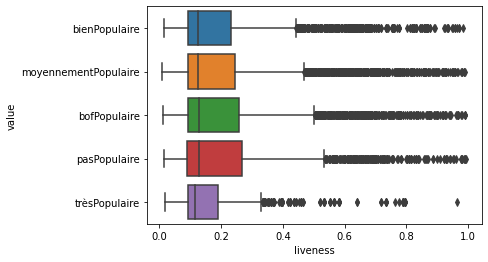

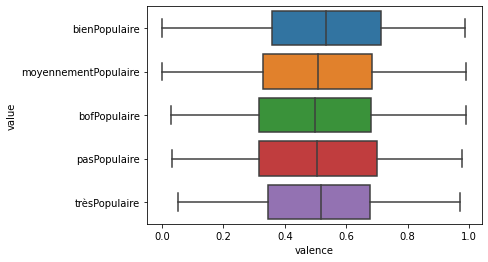

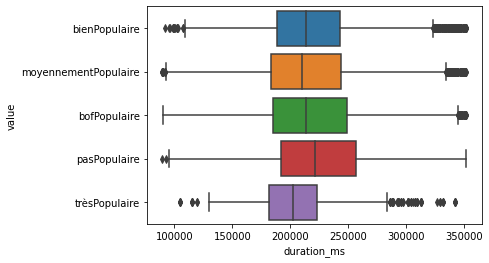

In [ ]:
var_quant = ["acousticness","mode","key","track_album_release_year","tempo","loudness","track_popularity","danceability","energy","speechiness","liveness","valence","duration_ms"]

for var in var_quant:
    sns.boxplot(x=var, y="value", data=data_long_popular)
    plt.show()


In [ ]:
spotify_data_quanti = data_short[["acousticness","tempo","track_popularity","valence"]]

[[ 6.50617315e-05  9.98193001e-01  6.00862503e-02  6.08737563e-04]
 [ 9.55617151e-04 -6.00866153e-02  9.98192564e-01  5.39463011e-04]
 [ 8.17003655e-01  3.25544677e-04 -4.50925092e-04 -5.76632220e-01]
 [ 5.76631693e-01 -4.74298515e-04 -1.02212870e-03  8.17003440e-01]]


<BarContainer object of 4 artists>

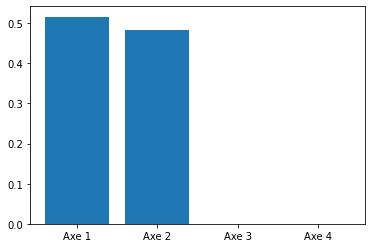

In [ ]:
cls = PCA(n_components=4)
pcs = cls.fit_transform(spotify_data_quanti)
print(cls.components_)
plt.bar(["Axe 1", "Axe 2", "Axe 3", "Axe 4"], cls.explained_variance_ratio_)

<AxesSubplot:>

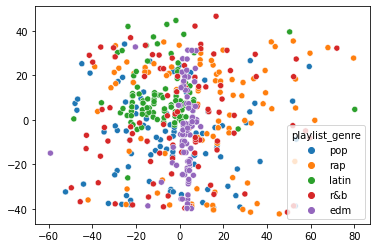

In [ ]:
sns.scatterplot(x=pcs[:,0],y=pcs[:,1],hue=data_short.playlist_genre)

In [ ]:
spotify_data_quanti = data_short[["acousticness","mode","key","track_album_release_year","tempo","loudness","track_popularity","danceability","energy","speechiness","liveness","valence","duration_ms"]]

[[ 3.26347106e-07 -3.68467574e-08 -2.29923316e-06 -2.18615767e-05
   2.23683650e-05 -1.32535270e-07 -4.49968894e-05 -4.14935670e-07
  -7.77095446e-08  9.65102512e-08 -1.09436637e-08 -1.21641169e-06
   9.99999998e-01]
 [ 7.84705584e-05 -2.10294920e-04 -3.81058682e-04 -5.04543086e-03
   9.93442843e-01  1.73718456e-02  1.12873921e-01 -6.53174074e-04
   1.20533996e-03  9.18066924e-04  3.34703579e-04  7.26071186e-04
  -1.72510041e-05]
 [ 1.02911569e-03  7.03175736e-04 -6.73736258e-04  2.51318528e-02
  -1.12798076e-01  3.94955238e-03  9.93291042e-01 -1.25171809e-04
  -3.82545201e-04 -9.62583827e-05  2.10840046e-04  2.54246554e-04
   4.77664413e-05]
 [-1.21658346e-03  1.85081664e-02 -9.99233158e-01  7.61137833e-03
   3.28160120e-04 -3.35639215e-02 -7.11952381e-04 -4.80880978e-04
  -1.51481078e-03  9.35917665e-04  4.37871196e-04 -6.20351183e-04
  -2.17497612e-06]]


<BarContainer object of 4 artists>

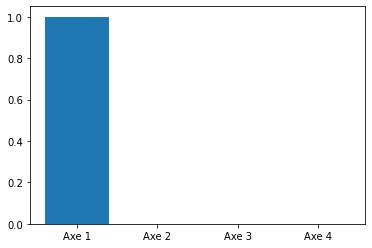

In [ ]:
cls = PCA(n_components=4)
pcs = cls.fit_transform(spotify_data_quanti)
print(cls.components_)
plt.bar(["Axe 1", "Axe 2", "Axe 3", "Axe 4"], cls.explained_variance_ratio_)

<AxesSubplot:>

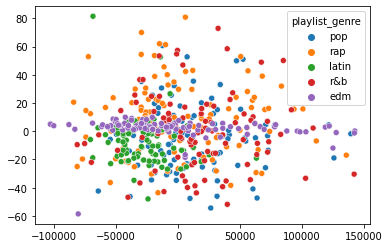

In [ ]:
sns.scatterplot(x=pcs[:,0],y=pcs[:,1],hue=data_short.playlist_genre)

In [ ]:
spotify_data_quanti = data_short[["speechiness","track_popularity","acousticness"]]

[[-1.77769740e-06  9.99999541e-01  9.57839544e-04]
 [-3.62578088e-03 -9.57839694e-04  9.99992968e-01]]


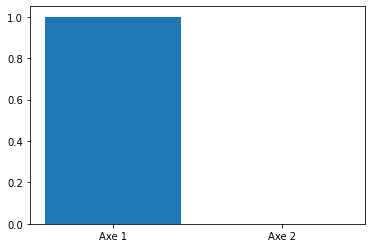

<AxesSubplot:>

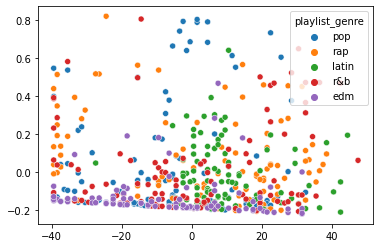

In [ ]:
cls = PCA(n_components=2)
pcs = cls.fit_transform(spotify_data_quanti)
print(cls.components_)
plt.bar(["Axe 1", "Axe 2"], cls.explained_variance_ratio_)
plt.show()
sns.scatterplot(x=pcs[:,0],y=pcs[:,1],hue=data_short.playlist_genre)

[[ 9.65102462e-08  3.26347117e-07 -4.14935669e-07  1.00000000e+00]
 [-7.66592905e-03  9.97138604e-01 -7.52053041e-02 -3.55878832e-07]]


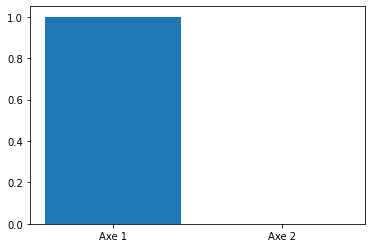

<AxesSubplot:>

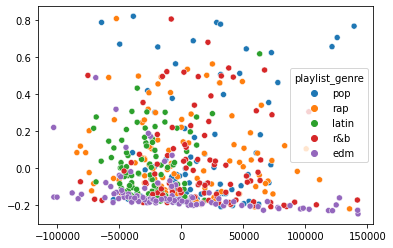

In [ ]:
spotify_data_quanti = data_short[["speechiness","acousticness","danceability","duration_ms"]]
cls = PCA(n_components=2)
pcs = cls.fit_transform(spotify_data_quanti)
print(cls.components_)
plt.bar(["Axe 1", "Axe 2"], cls.explained_variance_ratio_)
plt.show()
sns.scatterplot(x=pcs[:,0],y=pcs[:,1],hue=data_short.playlist_genre)

In [ ]:
data_short.speechiness = data_short.speechiness/0.6
data_short.speechiness



5367     0.051667
5368     0.053500
5369     0.052333
5370     0.051000
5371     0.048833
           ...   
28115    0.087833
28116    0.124167
28118    0.100333
28120    0.225000
28122    0.303333
Name: speechiness, Length: 500, dtype: float64

In [ ]:

def diviser_par_max():
    columns = ["danceability","energy","speechiness","acousticness","instrumentalness","liveness","valence","track_popularity"]
    for column in columns:
        Q1 = np.percentile(data_short[column], 25,interpolation = 'midpoint')
        Q3 = np.percentile(data_short[column], 75,interpolation = 'midpoint')
        IQR = Q3 - Q1
        mask = (data_short[column] < (Q3+1.5*IQR))
        mask2 = data_short[column] > (Q1-1.5*IQR)
        spotify_data_divided = data_short.loc[mask]
        spotify_data_divided = data_short.loc[mask2]
        spotify_data_divided[column] = spotify_data_divided[column]/spotify_data_divided[column].max()
    return spotify_data_divided

spotify_data_divided = diviser_par_max()
spotify_data_divided

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,playlist_name,playlist_id,playlist_genre,playlist_subgenre,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,track_album_release_month,track_album_release_year,popularity_quali
5367,6VdPR0ZgEcy7e3GVjcA5t1,It's Happening Again,Agnes Obel,0.590909,3jTTLPuVcL6J9pgujnU1lS,Citizen of Glass,Deep-deep Bubble Pop,744VClUYfFnZCDPcOUkg5G,pop,indie poptimism,...,0.051667,0.812000,0.3600,0.6060,0.0892,173.317,260493,10,2016,moyennementPopulaire
5368,3f8xfMuHb4cAbbrsmz6itv,Stone,Agnes Obel,0.511364,3jTTLPuVcL6J9pgujnU1lS,Citizen of Glass,Deep-deep Bubble Pop,744VClUYfFnZCDPcOUkg5G,pop,indie poptimism,...,0.053500,0.982000,0.1040,0.0970,0.2010,134.958,236602,10,2016,moyennementPopulaire
5369,1Zy6u7hhITR6qHYpYvg8yD,Trojan Horses,Agnes Obel,0.420455,3jTTLPuVcL6J9pgujnU1lS,Citizen of Glass,Deep-deep Bubble Pop,744VClUYfFnZCDPcOUkg5G,pop,indie poptimism,...,0.052333,0.926000,0.5180,0.1020,0.1490,105.892,333811,10,2016,bofPopulaire
5370,6Vq9kOWj1X6KIg4qPKuOO6,Citizen of Glass,Agnes Obel,0.477273,3jTTLPuVcL6J9pgujnU1lS,Citizen of Glass,Deep-deep Bubble Pop,744VClUYfFnZCDPcOUkg5G,pop,indie poptimism,...,0.051000,0.977000,0.1820,0.1050,0.1020,75.001,169354,10,2016,moyennementPopulaire
5371,0UnjUj5D9vPhYOPK4Ifwwh,Golden Green,Agnes Obel,0.431818,3jTTLPuVcL6J9pgujnU1lS,Citizen of Glass,Deep-deep Bubble Pop,744VClUYfFnZCDPcOUkg5G,pop,indie poptimism,...,0.048833,0.978000,0.0941,0.1120,0.4570,138.551,239703,10,2016,bofPopulaire
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28115,03MFnTJVWIB5e0uCTnGnr7,The Black Hole,Martin Numan,0.227273,6Xa2lq5fMJrEynm2i7Fy38,The Black Hole,House Electro 2019,72r6odw0Q3OWTCYMGA7Yiy,edm,electro house,...,0.087833,0.000286,0.8130,0.0982,0.7270,121.996,220328,03,2018,pasPopulaire
28116,62fMFW5ApAj4B8lXoRoXZU,Top Secret,Martin Numan,0.204545,6Xa2lq5fMJrEynm2i7Fy38,The Black Hole,House Electro 2019,72r6odw0Q3OWTCYMGA7Yiy,edm,electro house,...,0.124167,0.001800,0.9340,0.3260,0.7230,127.040,107813,03,2018,pasPopulaire
28118,1YVh7CgPXqGNg9lDD9Wg1P,Eclipse,Martin Numan,0.181818,6Xa2lq5fMJrEynm2i7Fy38,The Black Hole,House Electro 2019,72r6odw0Q3OWTCYMGA7Yiy,edm,electro house,...,0.100333,0.001810,0.9070,0.0596,0.8170,125.021,124800,03,2018,pasPopulaire
28120,2zvNrOXk8letDuim2sJpJj,Setwit,Martin Numan,0.204545,6Xa2lq5fMJrEynm2i7Fy38,The Black Hole,House Electro 2019,72r6odw0Q3OWTCYMGA7Yiy,edm,electro house,...,0.225000,0.027200,0.3210,0.0748,0.8460,127.982,120000,03,2018,pasPopulaire


[[-5.36710961e-04 -4.62609519e-02 -4.39485372e-01  3.35695522e-02
   6.72427595e-01 -4.20813498e-01 -6.56253873e-02 -2.11099808e-01
   3.54221169e-01]
 [-2.43783515e-04 -8.70357206e-02 -2.34796769e-01 -6.63331200e-02
   2.86122056e-01  4.41393575e-01 -8.07564096e-02 -5.02940192e-01
  -6.29865513e-01]
 [ 9.68961293e-05 -1.47568568e-01  1.06071648e-01 -1.56893268e-01
  -1.40019123e-01  4.75022304e-01  4.00746042e-02 -5.04314695e-01
   6.64203272e-01]
 [ 6.03890178e-04  1.29792732e-01 -1.14917548e-01 -3.62967986e-02
   4.13315671e-01  6.10978128e-01 -1.18871044e-01  6.18781294e-01
   1.65786761e-01]]


<BarContainer object of 4 artists>

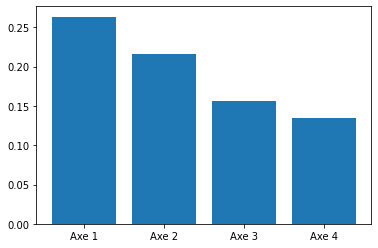

In [ ]:
spotify_data_divided.tempo = spotify_data_divided.tempo/100
spotify_data_divided_quanti = spotify_data_divided[["tempo","danceability","energy","speechiness","acousticness","instrumentalness","liveness","valence","track_popularity"]]

cls = PCA(n_components=4)
pcs = cls.fit_transform(spotify_data_divided_quanti)
print(cls.components_)
plt.bar(["Axe 1", "Axe 2", "Axe 3", "Axe 4"], cls.explained_variance_ratio_)

<AxesSubplot:>

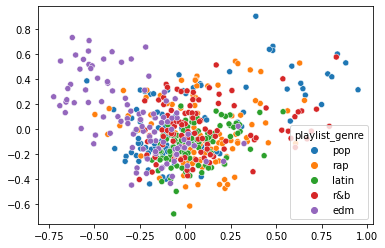

In [ ]:
sns.scatterplot(x=pcs[:,0],y=pcs[:,1],hue=spotify_data_divided.playlist_genre)

<AxesSubplot:>

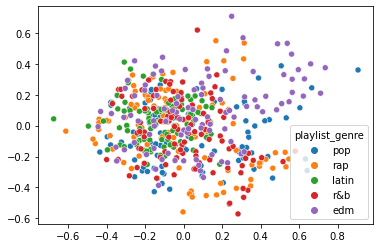

In [ ]:

sns.scatterplot(x=pcs[:,1],y=pcs[:,2],hue=spotify_data_divided.playlist_genre)

<AxesSubplot:>

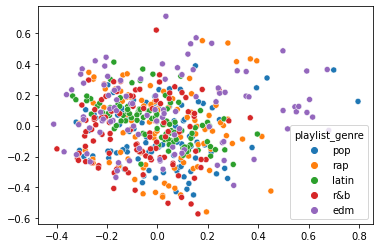

In [ ]:
sns.scatterplot(x=pcs[:,3],y=pcs[:,2],hue=spotify_data_divided.playlist_genre)

(<AxesSubplot:xlabel='PC1', ylabel='PC2'>, PCA(n_components=2))

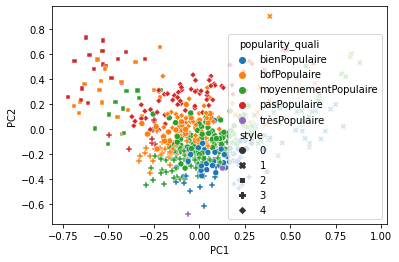

In [ ]:
cls = KMeans(n_clusters=5, init="k-means++", n_init = 100)
cls.fit(spotify_data_divided_quanti)
scatterplot_pca(data=spotify_data_divided_quanti,style=cls.labels_,hue=spotify_data_divided.popularity_quali)

In [ ]:
adjusted_rand_score(cls.labels_, spotify_data_divided.popularity_quali)


0.15163671486946326

(<AxesSubplot:xlabel='PC1', ylabel='PC2'>, PCA(n_components=2))

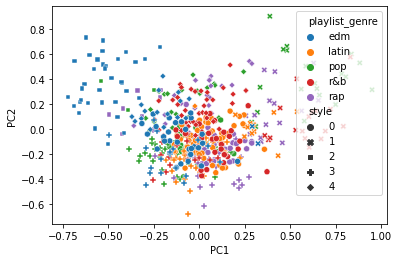

In [ ]:
cls = KMeans(n_clusters=5, init="k-means++", n_init = 100)
cls.fit(spotify_data_divided_quanti)
scatterplot_pca(data=spotify_data_divided_quanti,style=cls.labels_,hue=spotify_data_divided.playlist_genre)

In [ ]:
adjusted_rand_score(cls.labels_, spotify_data_divided.playlist_genre)

0.05832195034913237

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c2ad4461-7f35-42f5-b2d9-f686e8952f67' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>